In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import pandas as pd
import ast
import glob
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.impute import KNNImputer
from sklearn import metrics
from mpl_toolkits.axes_grid1 import make_axes_locatable
from umap import UMAP
from skimage import io
from itertools import product

plt.style.use('default')
#plt.style.use('dark_background')

DEFAULT_COLORS = np.array(('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'))
np.random.seed(105)

In [129]:
def load_data():
    """
    Load the results .csv file as pandas array
    :return: pandas dataframe
    """
    data = pd.read_csv('Result.csv', sep=';')
    return data


def patch_list_to_points(path, filter=False, structures=(1,)):
    """
    Extract all annotation lists from patchlist as a [n, 4] numpy array
    :param path: path to patchlist
    :return: numpy array
    """
    with open(path, 'r') as file:
        liste = [line.strip().split(";") for line in file]

    all_labels = []
    images = []
    coords = []
    all_structures = []
    all_ambiguous = []
    for row in liste:
        if int(row[4]) not in structures:
            continue
        all_labels.append(ast.literal_eval(row[5]))
        img_name = row[0].split("\\")[-1]
        images.append(img_name)
        coords.append([int(row[1]), int(row[2])])
        all_structures.append(int(row[4]))
        
        if len(row) > 7:
            ambiguous = ast.literal_eval(row[6])
        else:  # To consider patchlists made before the addition of the ? checkboxes
            ambiguous = np.array(ast.literal_eval(row[5])) == 0.5
            ambiguous = ambiguous.tolist()
        all_ambiguous.append(ambiguous)

    all_labels = all_labels
    coords = coords
    images = images
    all_structures = all_structures
    all_ambiguous = all_ambiguous

    if filter:
        all_labels, coords, images, all_structures = filter_points(all_labels, coords, images, all_structures)

    return all_labels, coords, images, all_structures, all_ambiguous

def filter_points(points, coords, images, structures):
    """
    Filters out any point with labels equal to 0.5
    :param points: array of shape (N, 4) of points with 4 features
    :return: filtered array
    """
    temp = points[:] == 0.5

    temp = np.sum(temp[:, :2], axis=1)

    indices = temp < 1
    out_points = points[indices, :]
    out_coords = coords[indices]
    out_images = images[indices]
    out_structures = structures[indices]

    return out_points, out_coords, out_images, out_structures

def impute_missing_labels(points, n_neighbors=5):
    """
    Use KNN to estimate missing labels
    :param point:
    :return:
    """
    imputer = KNNImputer(missing_values=np.nan, weights='distance', n_neighbors=n_neighbors)
    X = imputer.fit_transform(points)

    return X

def filter_structures_only(points, coords, images, structures):
    """
    Only keep points with strcutures == 1
    :param points:
    :param coords:
    :param images:
    :param structures:
    :return:
    """
    indices = structures == 1

    out_points = points[indices, :]
    out_coords = coords[indices]
    out_images = images[indices]
    out_structures = structures[indices]

    return out_points, out_coords, out_images, out_structures


def combine_labels(label_list, coords_list, images_list, structures_list, conditions_list, ambiguous_list):
    """
    Concatenate labels from a list of extracted patchlists
    :param label_list:
    :return: numpy array
    """
    labels = np.concatenate(label_list, axis=0).tolist()
    coords = np.concatenate(coords_list, axis=0).tolist()
    images = np.concatenate(images_list).tolist()
    structures = np.concatenate(structures_list).tolist()
    conditions = np.concatenate(conditions_list).tolist()
    ambiguous = np.concatenate(ambiguous_list).tolist()

    return labels, coords, images, structures, conditions, ambiguous


def scatter_labels(labels, legend, label_names=('Ruffles Qty', 'Ruffles Size', 'Fragmentation', 'Diffusion')):
    """
    Scatter plot of feature pairs
    :param labels:
    :param legend:
    :param label_names:
    :return:
    """
    for i in range(labels[0].shape[1]):
        for j in range(labels[0].shape[1]):
            if j <= i:
                continue
            for l, lbl in zip(labels, legend):
                #l = filter_points(l)
                x = l[:, i]
                y = l[:, j]

                plt.scatter(x, y, alpha=0.45, label=lbl)
            plt.xlabel(label_names[i])
            plt.ylabel(label_names[j])
            plt.xlim(-0.1,1.1)
            plt.ylim(-0.1,1.1)
            plt.legend()
            plt.show()

def label_clustering(features, seed=105, n_clusters=7, method='kmeans'):
    """
    Cluster labels
    :param labels_list:
    :param seed:
    :return:
    """
    if method == 'kmeans':
        knn = KMeans(n_clusters=n_clusters, random_state=seed)
    elif method == 'spectral':
        knn = SpectralClustering(n_clusters=n_clusters, random_state=seed)
    elif method == 'hierarchical':
        knn = AgglomerativeClustering(n_clusters=n_clusters)
    elif method == 'DBSCAN':
        knn = DBSCAN(eps=n_clusters)

    knn_labels = knn.fit_predict(features).astype('int').ravel()

    return features, knn_labels, knn

def load_image(image_name):
    """
    Find and load image into np array + convert into RGB for pretty pictures
    :param image_name: name of the image to load
    :return: image as RGB numpy array
    """
    image_name = image_name.translate(str.maketrans({'[':'[[]', ']':'[]]'}))  # stupidest shit ever
    image_path = glob.glob(f"images/*/*/*/{image_name}", recursive=True)
    print(image_path)
    image_path = image_path[0]
    image = io.imread(image_path).astype('float32')


    image[0] *= 255.0 / np.percentile(image[0], 99)
    image[1] *= 255.0 / np.percentile(image[1], 99)
    image = np.clip(image, 0, 255.0)
    image = (image).astype('uint8')


    image = np.array([image[0], image[1], np.zeros(image.shape[1:])])
    image = np.moveaxis(image, 0, -1).astype('uint8')
    #image = np.swapaxes(image, 0, 1).astype('uint8')
    return image


def localize_clusters(image, coords, labels, size=64, n_examples=0, im_name='', n_clusters=5, colors=DEFAULT_COLORS, save_path='crops'):
    """
    Localize the crops of each cluster in the original image
    :param image: original image
    :param coords: np array of coordinates
    :param labels: np array of classes
    :param size: Size of the crops
    :param n_examples: Number of examples of each class to extract
    :return:
    """

    ax = plt.subplot()
    ax.axis('off')
    ax.imshow(image)

    counts = [0 for _ in range(n_clusters)]
    for (y,x), c in zip(coords, labels):
        rect = patches.Rectangle((y,x), size, size, alpha=0.62, facecolor=colors[c], edgecolor='white', linewidth=0.33)
        ax.add_patch(rect)

        if np.random.random() < 0.5 and n_examples > 0:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            if counts[c] < n_examples:
                counts[c] += 1
                crop = image[x:x+size, y:y+size, 1]
                io.imsave(f'{save_path}/class_{c}-crop_{counts[c]}_{im_name}.tif', crop)

    return ax

def get_crops(image_names, coords, size=64):
    from tqdm import tqdm
    unique_names = np.unique(image_names)
    images = {}
    for im_name in unique_names:
        images[im_name] = load_image(im_name)
    
    crops = np.ndarray((0,size,size,3))
    for (x, y), im_name in tqdm(zip(coords, image_names)):
        image = images[im_name]
        crop = image[y:y+size, x:x+size]
        if (crop.shape[0] != size or crop.shape[1] != size):
            canvas = np.zeros((size, size, 3), dtype='uint8')
            canvas[:crop.shape[0], :crop.shape[1], :] = crop
            crop = canvas.copy()
        crop = np.expand_dims(crop,0)
        crops = np.concatenate((crops, crop), axis=0)
        
    return crops

def umap_clusters(X, y, method='UMAP', seed=105):
    """
    Generate the UMAP visualization of the clustering
    :param X: numpy array of features
    :param y: numpy array of classes found by clustering
    :param seed: random state
    :return:
    """
    if method == 'UMAP':
        umap = UMAP(n_components=2, n_neighbors=100, min_dist=0.5, random_state=seed)
    elif method == 'TSNE':
        umap = TSNE(n_components=2, perplexity=30, random_state=seed)
    elif method == 'PCA':
        umap = PCA(n_components=2, random_state=seed)

    if method == 'Raw':
        assert X.shape[-1] != 2, "Can only use the 'Raw' method with 2D data"
        umap_data = X
    else:
        umap_data = umap.fit_transform(X)

    return umap_data

    
def plot_umap(X, y, labels=None, legend='Class', title='UMAP Visualization of K-Means Clustering', filename='umap'):
    """
    Generate the UMAP visualization of the clustering
    :param X: numpy array of features
    :param y: numpy array of classes found by clustering
    :param seed: random state
    :return:
    """
    plt.figure(figsize=(4,4))
    
    if labels is None:
        labels = np.unique(y)

    for l in np.unique(y):
        idx = y == l

        plt.scatter(X[idx,0], X[idx,1], alpha=0.45, label=labels[l], c=DEFAULT_COLORS[l])
        #plt.xlabel(label_names[i])
        #plt.ylabel(label_names[j])
    plt.legend(title=legend)
    plt.title(title)
    plt.savefig(f'{filename}.pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    
def plot_umap_hover(X, y, crops, features, labels=None, legend='Class', title='UMAP Visualization of K-Means Clustering', filename='umap'):
    """
    Generate the *interactive* UMAP visualization of the clustering
    :param X: numpy array of features
    :param y: numpy array of classes found by clustering
    :param seed: random state
    :return:
    """
    from matplotlib import colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox

    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111)
    
    if labels is None:
        labels = np.unique(y)

    plot = ax.scatter(X[:,0], X[:,1], alpha=0.45, c=DEFAULT_COLORS[y])
    
    # Stuff for hovering
    print(crops.dtype)
    im = OffsetImage(crops[0], zoom=1)
    xybox=(64,64)
    ab = AnnotationBbox(im, (8,8), xybox=xybox, xycoords='data', boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)
    ab.set_visible(False)
    
    text_label = f"""Ruffles Qty: 0\nRuffles Size: 0\nFragmentation: 0\nDiffusion: 0"""
    text = ax.text(0.05, 0.95, text_label, horizontalalignment='left', verticalalignment='top', transform = ax.transAxes)
    text.set_visible(False)
        
    def hover(event):
        sc = ax.collections[0] 
        # if the mouse is over the scatter points
        contains, ind = sc.contains(event)
        #ind = ind[0]
        if contains:
            ind = ind['ind'][0]
            # find out the index within the array from the event

            # get the figure size
            w,h = fig.get_size_inches()*fig.dpi
            ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
            hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
            # if event occurs in the top or right quadrant of the figure,
            # change the annotation box position relative to mouse.
            ab.xybox = (xybox[0]*ws, xybox[1]*hs)
            # make annotation box visible
            ab.set_visible(True)
            # place it at the position of the hovered scatter point
            ab.xy =(X[ind, 0], X[ind, 1])
            # set the image corresponding to that point
            im.set_data(crops[ind,:,:])
            
            text_label = f"Ruffles Qty: {features[ind,0]}\nRuffles Size: {features[ind,1]}\nFragmentation: {features[ind,2]}\nDiffusion: {features[ind,3]}"
            text.set_text(text_label)
            text.set_visible(True)
        else:
            #if the mouse is not over a scatter point
            ab.set_visible(False)
            text.set_visible(False)
        fig.canvas.draw_idle()
        
    plt.title(title)
    fig.canvas.mpl_connect('motion_notify_event', hover)   
    plt.show(block=True)

def quantify_clusters(X, y):
    """
    Show average features of different clusters
    :param X: features
    :param y: cluster indicex
    :return:
    """
    cluster_array = []
    for l in np.unique(y):
        idx = y == l
        l_X = X[idx]

        cluster_array.append(list(np.median(l_X, axis=0)))

    cluster_array = np.array(cluster_array)

    plt.figure(figsize=(2,2))
    ax = plt.subplot()
    mat = ax.matshow(cluster_array, vmin=0, vmax=1)
    ax.set_xticks(np.arange(X.shape[-1]))
    ax.set_xticklabels([f'Class {c}' for c in range(X.shape[-1])], rotation=45)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(mat, cax=cax)
    plt.savefig('codebar.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

def classify_by_values(X):
    """
    Transform values to classes
    :param X:
    :return:
    """

    out_X = np.where(X < 0.5, 0, X)
    out_X = np.where(out_X > 0.5, 2, out_X)
    out_X = np.where(out_X == 0.5, 1, out_X)

    return out_X.astype('uint8')


def count_classes(labels):
    """
    Count the amount of each class for plottin'
    :param X:
    :return:
    """
    counts = [[], [], []]
    for c in (0,1,2):
        counts[c] = (list(np.sum(labels == c, axis=0)))

    counts = np.array(counts).T

    return np.array(counts)

def plot_bars(counts, title):
    """
    Just count how many of each class there is and do a lil bar graph
    """
    # Linear - Lots of Ruffles
    # Small ruffles - Big ruffles
    # Continuous - Fragmented
    # Sharp - Diffuse

    features = [1,2,3,4]
    classes = ['< 0.5', '= 0.5', '> 0.5']
    plt.figure(figsize=(2,2), dpi=100)

    for c in range(3):
        offset = 0.20*(c-1)
        x = np.array([1,2,3,4])+offset
        plt.bar(x,counts[:,c], width=0.20, label=classes[c], edgecolor='black', linewidth='1.0')

    plt.xticks((1,2,3,4), features)
    plt.ylabel('Number of crops')
    plt.xlabel('Class')
    plt.title(title)
    plt.legend()
    plt.savefig(f'bars_{title}.pdf', bbox_inches='tight', dpi=450)
    plt.show()
    plt.close()

def plot_feature_distribution(features, title=''):
    """
    Plot a histogram of the distribution of features' values
    :param features:
    :return:
    """

    fig, axes = plt.subplots(4,1,sharey='all' ,sharex='all')
    for f in range(features.shape[1]):
        axes[f].hist(features[:,f], bins=np.arange(0,1.06,0.05), edgecolor='black', linewidth=1.0)
        #axes[f].set_ylim(0,160)
    plt.xticks(np.arange(0,1.06,0.1))
    #plt.title(f'Class {f+1}')
    plt.xlabel('Feature value')
    plt.ylabel('Number of crops')
    #plt.show()
    plt.savefig(f'hist_features.pdf', bbox_inches='tight', dpi=450)
    axes[0].set_title(title)
    plt.show()
    plt.close()

def quantify_cluster_proportions(classes, images):
    """
    Quantify the amount of crops in each cluster for every image
    :param y: classes
    :param images: image names
    :return:
    """

    all_images = np.unique(images)
    all_classes = np.unique(classes)

    for i, img in enumerate(all_images):
        plt.figure(figsize=(2, 2), dpi=100)
        counts = np.array([0 for _ in all_classes])
        y = classes[images == img]

        for c in all_classes:
            counts[i][c] += np.sum(y == c)

        plt.bar(all_classes, counts/len(y), color=DEFAULT_COLORS, edgecolor='black', linewidth=1.0)
        plt.title(f'Image {i+1}')
        plt.ylim(0,0.5)
        plt.xlabel('Cluster')
        plt.ylabel('Proportion of crops')
        plt.xticks(all_classes, all_classes)
        #plt.show()
        plt.savefig(f'n_classes_{img}.pdf', bbox_inches='tight', dpi=450)
        plt.show()
        plt.close()
        
def quantify_cluster_proportions_cond(classes, conditions):
    """
    Quantify the amount of crops in each cluster for every condition
    :param y: classes
    :param conditions: conditions
    :return:
    """

    all_conditions = np.unique(conditions)
    all_classes = np.unique(classes)

    for i, cond in enumerate(all_conditions):
        plt.figure(figsize=(2, 2), dpi=100)
        counts = np.array([0 for _ in all_classes])
        y = classes[conditions == cond]

        for c in all_classes:
            counts[c] += np.sum(y == c)

        plt.bar(all_classes, counts/len(y), color=DEFAULT_COLORS, edgecolor='black', linewidth=1.0)
        plt.title(cond)
        plt.ylim(0,0.5)
        plt.xlabel('Cluster')
        plt.ylabel('Proportion of crops')
        plt.xticks(all_classes, all_classes)
        #plt.show()
        plt.savefig(f'n_classes_{cond}.pdf', bbox_inches='tight', dpi=450)
        plt.show()
        plt.close()
        
def quantify_cluster_proportions_images(classes, conditions, images, ymin=None, ymax=None):
    """
    Quantify the amount of crops in each cluster for every condition + stack by image!
    :param y: classes
    :param conditions: conditions
    :return:
    """

    all_conditions = np.unique(conditions)
    all_classes = np.unique(classes)
    all_images = np.unique(images)

    
    for i, cond in enumerate(all_conditions):
        total_crops = len(classes[conditions == cond])
        
        plt.figure(figsize=(2, 2), dpi=100)
        counts_total = np.array([0 for _ in all_classes])
        y = classes[conditions == cond]
        img_cond = images[conditions == cond]
        
        for j, img in enumerate(np.unique(img_cond)):
            counts = np.array([0 for _ in all_classes])
            y_im = y[img_cond == img]
            for c in all_classes:
                counts[c] += np.sum(y_im == c)
                
            colors = []
            for col in DEFAULT_COLORS:
                colors.append(tuple(int(col[i:i+2], 16) for i in (1, 3, 5)))
            colors = np.array(colors)
            colors += 60*(j-2)
            colors = np.array(colors)/255
            colors = np.clip(colors,0,1)
            
            #edges = [(0.0, 0.0, 0.4), 
            #         (0.0, 0.4, 0.0), 
            #         (0.4, 0.0, 0.0), 
            #         (0.2, 0.0, 0.4)]
            plt.bar(all_classes, counts/total_crops, color=colors, edgecolor='black', linewidth=1.0, bottom=counts_total/total_crops)
            counts_total += counts
        plt.title(cond)
        plt.ylim(ymin, ymax)
        plt.xlabel('Cluster')
        plt.ylabel('Number of crops')
        plt.xticks(all_classes, all_classes)
        #plt.show()
        plt.savefig(f'n_classes_{cond}.pdf', bbox_inches='tight', dpi=450)
        plt.show()
        plt.close()
        
def quantify_cluster_proportions_average(classes, conditions, images):
    """
    Quantify the amount of crops in each cluster for every condition
    :param y: classes
    :param conditions: conditions
    :param images: images
    :return:
    """

    all_conditions = np.unique(conditions)
    all_classes = np.unique(classes)
    all_images = np.unique(images)

    for i, cond in enumerate(all_conditions):
        plt.figure(figsize=(2, 2), dpi=100)
        y = classes[conditions == cond]
        imgs = images[conditions == cond]

        #counts = np.array([[0 for _ in all_classes] for _ in np.unique(imgs)])
        counts = np.zeros((len(np.unique(imgs)), len(all_classes)))
        print(counts.shape)
        for idx, im in enumerate(np.unique(imgs)):
            y_img = y[imgs == im]
            for c in all_classes:
                counts[idx, c] += np.sum(y_img == c)
        counts = counts / np.sum(counts, axis=1)[:,None]
                
        counts = np.mean(counts, axis=0)
        error = np.std(counts, axis=0)

        plt.bar(all_classes, counts, yerr=error, color=DEFAULT_COLORS, edgecolor='black', linewidth=1.0)
        plt.title(cond)
        plt.ylim(0,0.5)
        plt.xlabel('Cluster')
        plt.ylabel('Proportion of crops')
        plt.xticks(all_classes, all_classes)
        #plt.show()
        plt.savefig(f'n_classes_{cond}_avg.pdf', bbox_inches='tight', dpi=450)
        plt.show()
        plt.close()

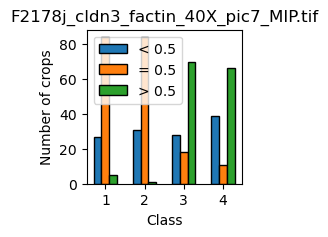

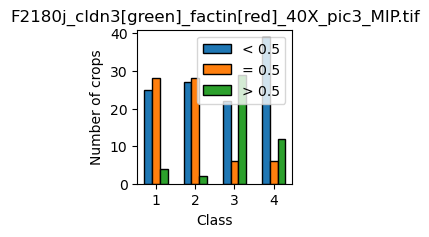

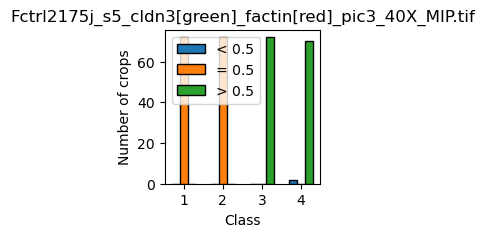

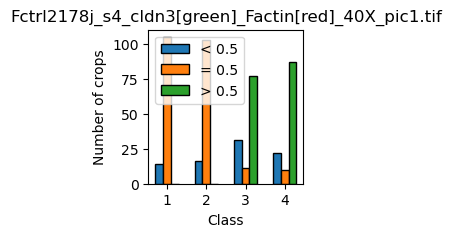

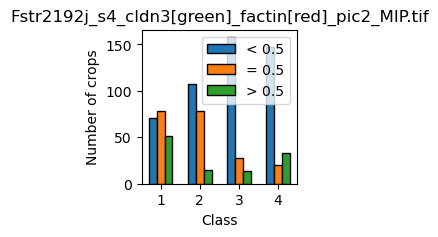

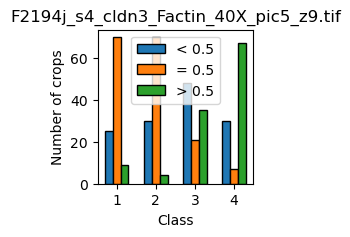

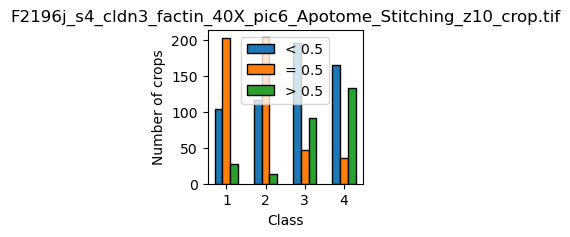

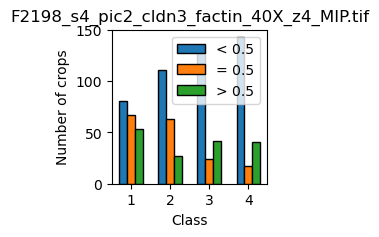

In [3]:
#paths = ('patchlist1_32.txt', 'patchlist2.txt', 'patchlist3_ancienLog_32_nouveauLog.txt', 'patchlist4.txt', 'patchlist5.txt')
condition_paths = {'Control'  : ['Image5', 'Image6', 'Image7', 'Image8'],
                   'Stressed' : ['Image1', 'Image2', 'Image3', 'Image4']}

feature_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

features_list, coords_list, images_list, structures_list, conditions_list, ambiguous_list = [], [], [], [], [], []


for cond in condition_paths.keys():
    for i, p in enumerate(condition_paths[cond]):
        data_path = glob.glob(f'images/{p}/*/*/patchlist*.txt')[0]
        
        features, coords, images, structures, ambiguous = patch_list_to_points(data_path, filter=False, structures=(1,))

        class_counts = count_classes(classify_by_values(np.array(features)[np.array(structures) == 1]))
        plot_bars(class_counts, images[0])

        features_list.append(features)
        coords_list.append(coords)
        images_list.append(images)
        structures_list.append(structures)
        conditions_list.append([cond for _ in range(len(images))])
        ambiguous_list.append(ambiguous)

# TODO: A nice pandas dataframe instead of this stupid thing
features, coords, images, structures, conditions, ambiguous = combine_labels(features_list, coords_list, images_list, structures_list, conditions_list, ambiguous_list)

# Impute missing/unclear labels
#features = np.array(features)
#print(features)
#print(np.array(ambiguous))
#features[ambiguous] = np.nan
#features = impute_missing_labels(features, n_neighbors=5)
#features = features.tolist()

df_dict = {'features': features,
           'coords': coords,
           'images': images,
           'structures': structures,
           'conditions': conditions,
           'ambiguous': ambiguous}

data = pd.DataFrame(df_dict)


In [ ]:
# Filter out ambiguous
data = data[data['ambiguous'].map(np.sum) == 0]

In [4]:
f_arr = np.array(data['features'].values.tolist())
a_arr = np.array(data['ambiguous'].values.tolist())
print(f_arr.shape)
print(a_arr.shape)

f_arr[a_arr[:,0] == True, 0] = 0.0
f_arr[a_arr[:,1] == True, 1] = 0.0

data_2 = data.copy()
data_2['features'] = f_arr.tolist()

data = data_2

(1203, 4)
(1203, 4)


[1 3]
['images\\Image5\\Image5\\TIFF input\\F2178j_cldn3_factin_40X_pic7_MIP.tif']


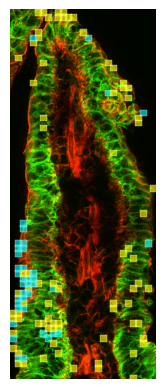

[1 3]
['images\\Image6\\6. Fctrl2180j_cldn3[Green]_factin[Red]_40X_pic3_MIP\\TIFF input\\F2180j_cldn3[green]_factin[red]_40X_pic3_MIP.tif']


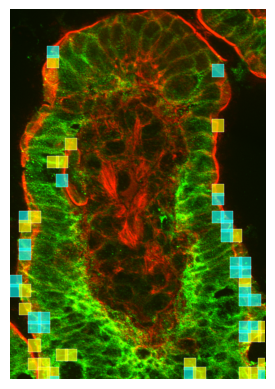

[1 3]
['images\\Image2\\2. F2194j_s4_cldn3_Factin_40X_pic5_Apotome_Stitching_z9\\F2194_Tiff input\\F2194j_s4_cldn3_Factin_40X_pic5_z9.tif']


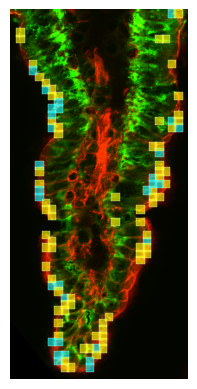

[1 3]
['images\\Image3\\3. F2196j_s4_cldn3_factin_40X_pic6_Apotome_Stitching_z10\\F2196j_pic6_TIFF input\\F2196j_s4_cldn3_factin_40X_pic6_Apotome_Stitching_z10_crop.tif']


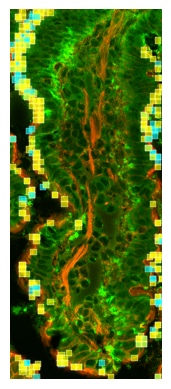

[1 3]
['images\\Image4\\4. F2198j_s4_cldn3_factin_40X_pic2_Apotome_Stitching_z4_MIP\\F2198_pic2 TIFF input MIP\\F2198_s4_pic2_cldn3_factin_40X_z4_MIP.tif']


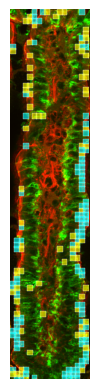

[1 3]
['images\\Image7\\8. Fctrl2175j_cldn3[Green]_factin[Red]_40X_pic3_MIP\\TIFF input\\Fctrl2175j_s5_cldn3[green]_factin[red]_pic3_40X_MIP.tif']


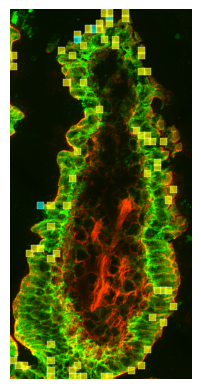

[1 3]
['images\\Image8\\9. Fctrl2178j_cldn3[green]_Factin[red]_40X_pic1_MIP\\Input\\Fctrl2178j_s4_cldn3[green]_Factin[red]_40X_pic1.tif']


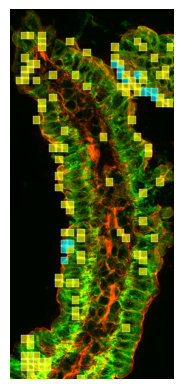

[1 3]
['images\\Image1\\7. Fstr2192j_cldn3[Green]_factin[Red]_40X_pic2_MIP\\Input\\Fstr2192j_s4_cldn3[green]_factin[red]_pic2_MIP.tif']


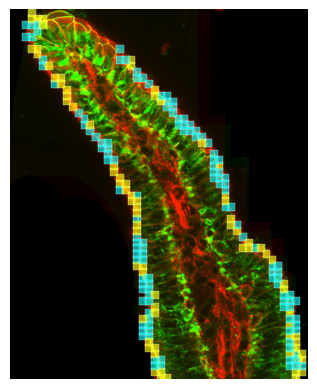

In [58]:
# Show where ambiguous vs structure
y = np.array(data['structures'].values)
for img_name in np.unique(data['images']):
    img_df = data.loc[data['images'] == img_name]
    im_y = img_df['structures'].values
    im_y[img_df['ambiguous'].map(np.sum) > 0] = 3
    print(np.unique(im_y))
    im_coords = img_df['coords'].values.tolist()

    try:
        image = load_image(img_name)
    except IndexError:
        continue
    localize_clusters(image, im_coords, im_y, colors=['black', 'cyan', 'red', 'yellow'], n_examples=10, save_path=f'crops/{img_name}')
    plt.title('')
    plt.savefig(f'structures_{img_name[:-4]}.png', bbox_inches='tight', dpi=450)
    plt.show()
    plt.close()

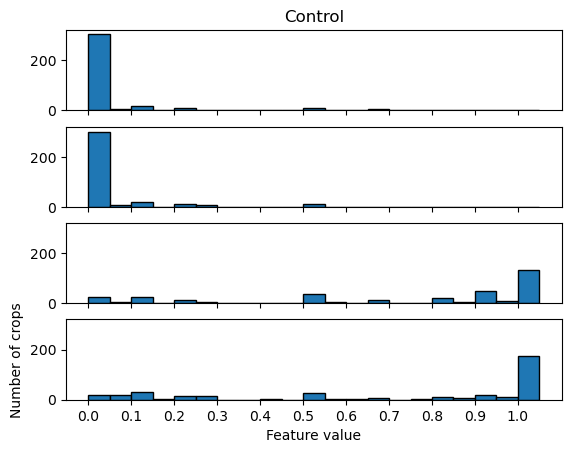

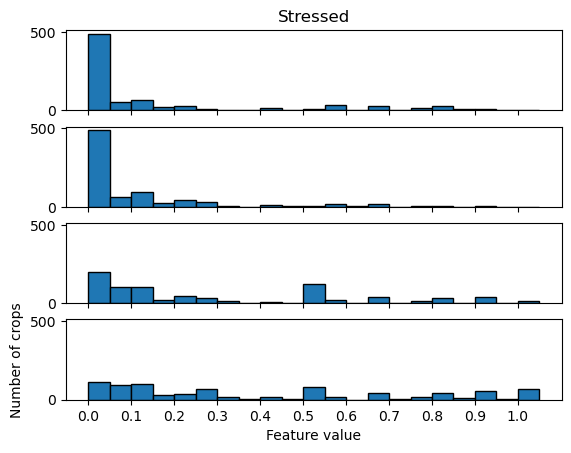

In [6]:
# Basic quantification
X = np.array(data.loc[data['conditions'] == 'Control']['features'].values.tolist())
plot_feature_distribution(X, 'Control')

X = np.array(data.loc[data['conditions'] == 'Stressed']['features'].values.tolist())
plot_feature_distribution(X, 'Stressed')

#class_X = classify_by_values(X)
#print(class_X)
#for c in range(4):
#    y = class_X[:, c]
#    for img_name in np.unique(data['images']):
#        im_y = y[images == img_name]
#        im_coords = coords[images == img_name]

#        image = load_image(img_name)
#        localize_clusters(image, im_coords, im_y)
#        plt.title(feature_names[c])
#        plt.savefig(f'{feature_names[c]}_{img_name[:-4]}.pdf', bbox_inches='tight', dpi=450)
#        plt.show()
#        plt.close()

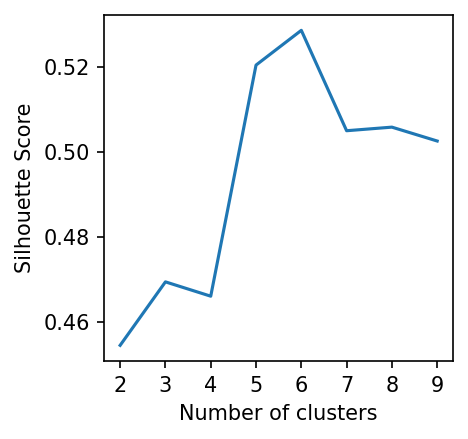

Best number of clusters:  6
Silhouette score:  0.5285674171718475


In [5]:
# Find best number of clusters using silhouette score
features = np.array(data['features'].values.tolist())
sil = []
cluster_range = np.arange(2, 10)
for n_clusters in cluster_range:
    X, y, knn_model = label_clustering(features, n_clusters=n_clusters, method='kmeans')
    sil.append(metrics.silhouette_score(X, y))

n_clusters = cluster_range[np.argmax(sil)]

plt.figure(figsize=(3,3), dpi=150)
plt.plot(cluster_range, sil)
plt.xticks(cluster_range)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

print('Best number of clusters: ', n_clusters)
print('Silhouette score: ', np.max(sil))


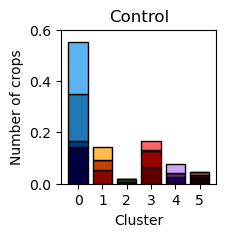

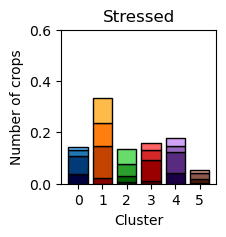

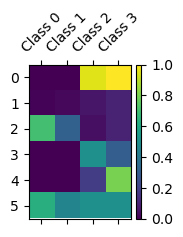

In [6]:
# Clustering
X, y, knn_model = label_clustering(features, n_clusters=n_clusters, method='kmeans')
    
#quantify_cluster_proportions_cond(y, data['conditions'])
quantify_cluster_proportions_images(y, data['conditions'], data['images'], ymax=0.60)
#quantify_cluster_proportions_average(y, data['conditions'], data['images'])
quantify_clusters(X, y)

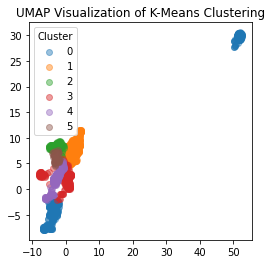

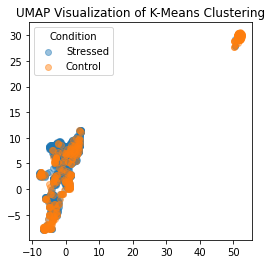

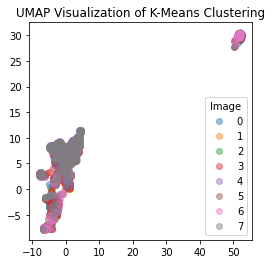

In [130]:
%matplotlib inline
# U-Map visualization
# Full
umap_X = umap_clusters(X, y, method='UMAP')
plot_umap(umap_X, y, legend='Cluster')

# Control vs stressed
conditions = data['conditions']
conditions = conditions.replace('Control', 1)
conditions = conditions.replace('Stressed', 0)
conditions = conditions.to_numpy()
plot_umap(umap_X, conditions, labels=['Stressed', 'Control'], legend='Condition', filename='umap_conditions')

# By image
images = data['images']
for n, i in enumerate(np.unique(images)):
    images = images.replace(i, n)
images = images.to_numpy()
plot_umap(umap_X, images, labels=None, legend='Image', filename='umap_images')



In [ ]:
for img_name in np.unique(data['images']):
    img_df = data.loc[data['images'] == img_name]
    im_y = y[data['images'] == img_name]
    im_coords = img_df['coords'].values.tolist()

    #im_y = y[images == img_name]
    #im_coords = coords[images == img_name]

    image = load_image(img_name)
    localize_clusters(image, im_coords, im_y, n_examples=50, n_clusters=n_clusters, im_name=img_name)
    plt.title('Clustering Classes')
    plt.savefig(f'clustering_{img_name[:-4]}.pdf', bbox_inches='tight', dpi=450)
    plt.show()
    plt.close()

#### Interactive projection

In [116]:
crops = get_crops(data['images'], data['coords'])
print(crops.shape)

['images\\Image5\\Image5\\TIFF input\\F2178j_cldn3_factin_40X_pic7_MIP.tif']
['images\\Image6\\6. Fctrl2180j_cldn3[Green]_factin[Red]_40X_pic3_MIP\\TIFF input\\F2180j_cldn3[green]_factin[red]_40X_pic3_MIP.tif']
['images\\Image2\\2. F2194j_s4_cldn3_Factin_40X_pic5_Apotome_Stitching_z9\\F2194_Tiff input\\F2194j_s4_cldn3_Factin_40X_pic5_z9.tif']
['images\\Image3\\3. F2196j_s4_cldn3_factin_40X_pic6_Apotome_Stitching_z10\\F2196j_pic6_TIFF input\\F2196j_s4_cldn3_factin_40X_pic6_Apotome_Stitching_z10_crop.tif']
['images\\Image4\\4. F2198j_s4_cldn3_factin_40X_pic2_Apotome_Stitching_z4_MIP\\F2198_pic2 TIFF input MIP\\F2198_s4_pic2_cldn3_factin_40X_z4_MIP.tif']
['images\\Image7\\8. Fctrl2175j_cldn3[Green]_factin[Red]_40X_pic3_MIP\\TIFF input\\Fctrl2175j_s5_cldn3[green]_factin[red]_pic3_40X_MIP.tif']
['images\\Image8\\9. Fctrl2178j_cldn3[green]_Factin[red]_40X_pic1_MIP\\Input\\Fctrl2178j_s4_cldn3[green]_Factin[red]_40X_pic1.tif']
['images\\Image1\\7. Fstr2192j_cldn3[Green]_factin[Red]_40X_pic2_MI

1203it [00:28, 41.65it/s]

(1203, 64, 64, 3)


In [70]:
%matplotlib inline

<IPython.core.display.Javascript object>


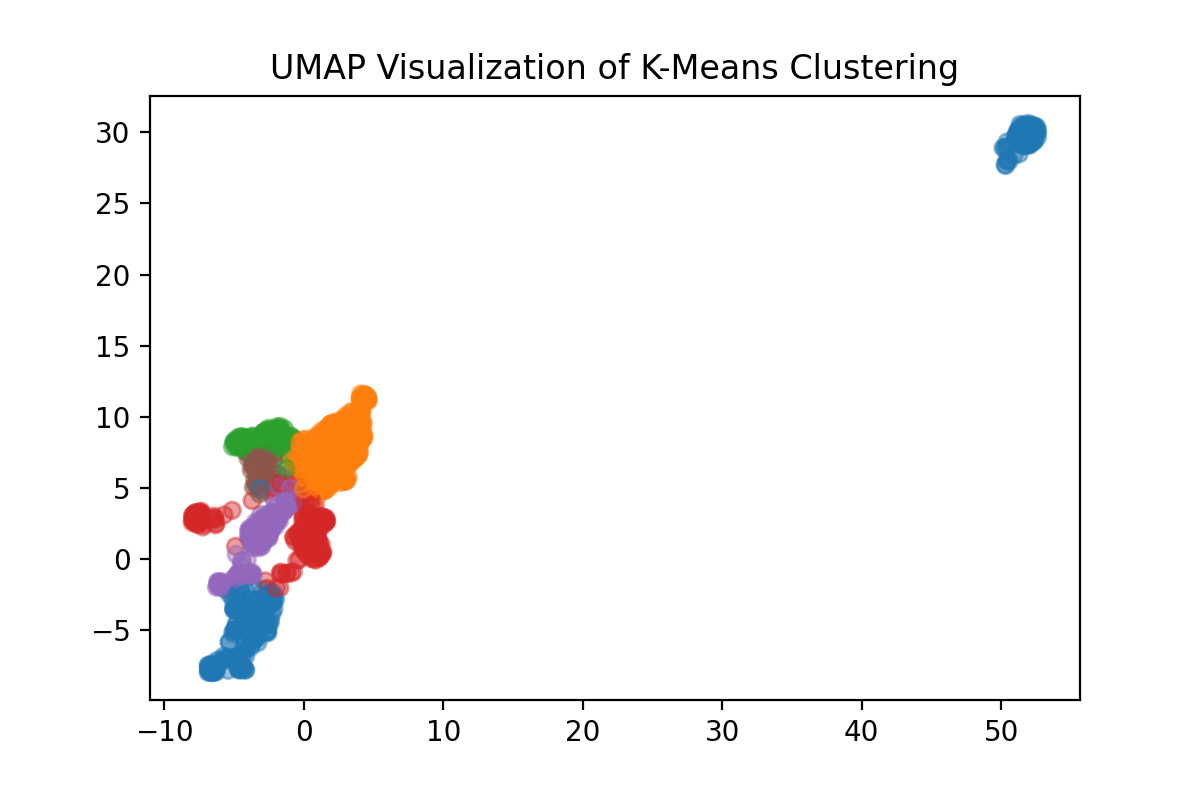

uint8


In [131]:
%matplotlib notebook
crops = crops.astype('uint8')
crops_norm = crops.copy()
crops_norm[...,0] = 0
max_int = np.max(crops_norm[...,1], axis=(1,2))[:,None,None]
crops_norm[...,1] = (crops_norm[...,1] / max_int * 255).astype('uint8')
feats = np.array(data['features'].values.tolist())
plot_umap_hover(umap_X, y, crops=crops_norm, features=feats, legend='Cluster')

## Trying do do stuff with missing data

##### Clustering with classes 3 and 4 only :)

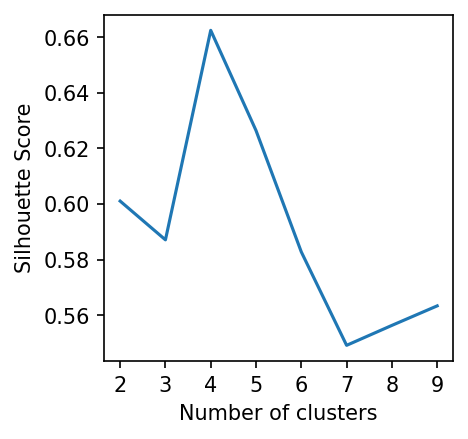

Best number of clusters:  4
Silhouette score:  0.6624949874611205


In [9]:
# Find best number of clusters using silhouette score

# Filter out ambiguous
ambiguous_array = np.array(data['ambiguous'].values.tolist())
indices = np.sum(ambiguous_array[:,-2:], axis=1) == 0
data = data[indices]

features = np.array(data['features'].values.tolist())
features = features[:,-2:]
sil = []
cluster_range = np.arange(2, 10)
for n_clusters in cluster_range:
    X, y, knn_model = label_clustering(features, n_clusters=n_clusters, method='kmeans')
    sil.append(metrics.silhouette_score(X, y))

n_clusters = cluster_range[np.argmax(sil)]

plt.figure(figsize=(3,3), dpi=150)
plt.plot(cluster_range, sil)
plt.xticks(cluster_range)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

print('Best number of clusters: ', n_clusters)
print('Silhouette score: ', np.max(sil))


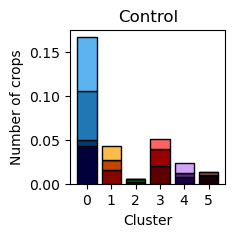

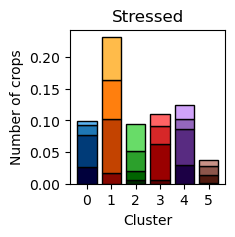

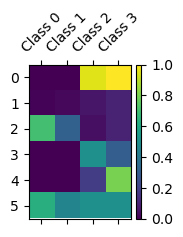

In [9]:
# Clustering
X, y, knn_model = label_clustering(features, n_clusters=n_clusters, method='kmeans')
    
#quantify_cluster_proportions_cond(y, data['conditions'])
quantify_cluster_proportions_images(y, data['conditions'], data['images'])
#quantify_cluster_proportions_average(y, data['conditions'], data['images'])
quantify_clusters(X, y)


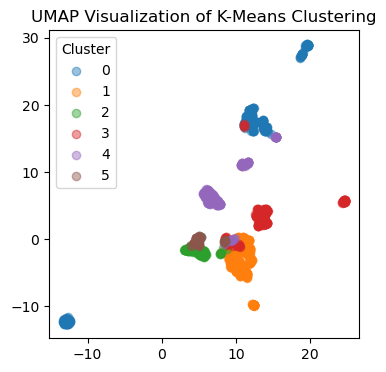

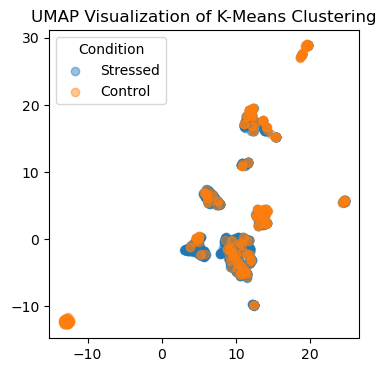

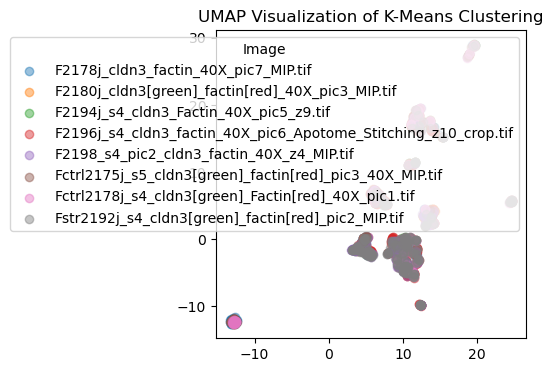

In [10]:
# U-Map visualization
# Full
umap_X = umap_clusters(X, y, method='UMAP')
plot_umap(umap_X, y, legend='Cluster')

# Control vs stressed
conditions = data['conditions']
conditions = conditions.replace('Control', 1)
conditions = conditions.replace('Stressed', 0)
conditions = conditions.to_numpy()
plot_umap(umap_X, conditions, labels=['Stressed', 'Control'], legend='Condition', filename='umap_conditions')

# By image
images = data['images']
for n, i in enumerate(np.unique(images)):
    images = images.replace(i, n)
images = images.to_numpy()
plot_umap(umap_X, images, labels=np.unique(data['images']), legend='Image', filename='umap_images')

[False False  True ... False  True  True]


C:\Users\Renaud\AppData\Local\Temp/ipykernel_7112/1595018311.py:255: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.scatter(X[idx,0], X[idx,1], alpha=0.45, label=labels[l], c=DEFAULT_COLORS[l])


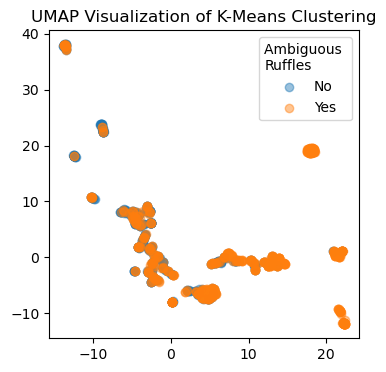

In [12]:
# Look at where on this classes 1 & 2 are ambiguous

# Filter out ambiguous
ambiguous_array = np.array(data['ambiguous'].values.tolist())
classes = np.sum(ambiguous_array[:,:2], axis=1) > 0
print(classes)
plot_umap(umap_X, classes, labels=['No', 'Yes'], legend='Ambiguous \nRuffles', filename='Ambiguous')

445.0
626.0


C:\Users\Renaud\AppData\Local\Temp/ipykernel_7112/3689355593.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  hist = plt.hist(x_class, bins=np.arange(0,1.1,0.1), alpha=0.75, edgecolor='black', rwidth=1, label=legend_labels[c], density=False)


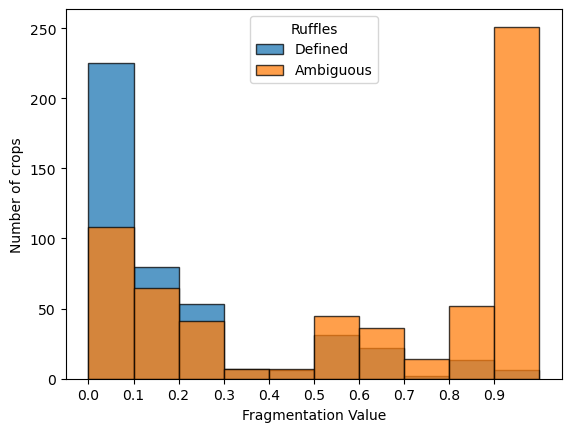

445.0
626.0


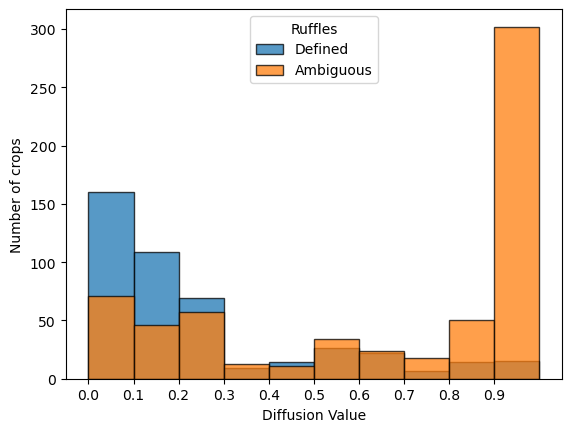

In [14]:
# Plot distribution of fragmentation/diffusion according to ruffle ambiguity
legend_labels = ('Defined', 'Ambiguous')
for f, title in zip((2,3), ('Fragmentation', 'Diffusion')):
    x = np.array(data['features'].values.tolist())
    x = x[:,f]
    for c in np.unique(classes):
        x_class = x[classes == c]
        hist = plt.hist(x_class, bins=np.arange(0,1.1,0.1), alpha=0.75, edgecolor='black', rwidth=1, label=legend_labels[c], density=False)
        print(np.sum(hist[0]))
    #plt.title(title)
    plt.ylabel('Number of crops')
    plt.xlabel(f'{title} Value')
    plt.xticks(np.arange(0,1.0,0.1), np.arange(0.0,1.0,0.1).astype('float32'))
    plt.legend(title='Ruffles', loc='upper center')
    plt.show()
    plt.close()


Control


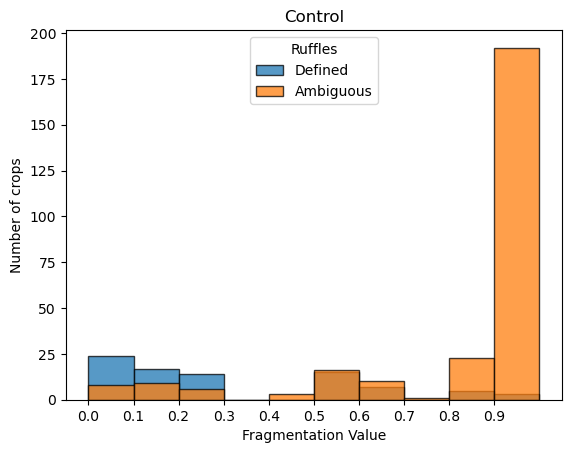

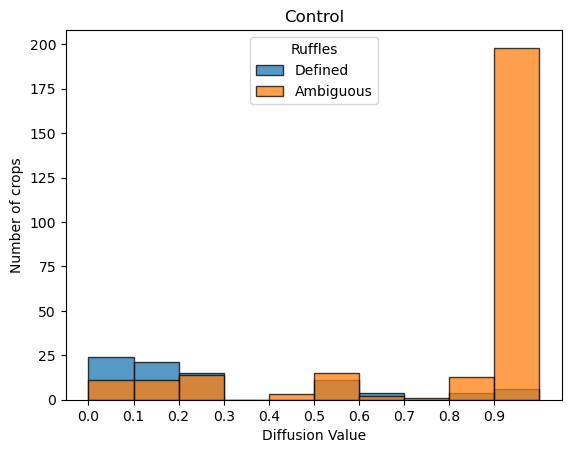

Stressed


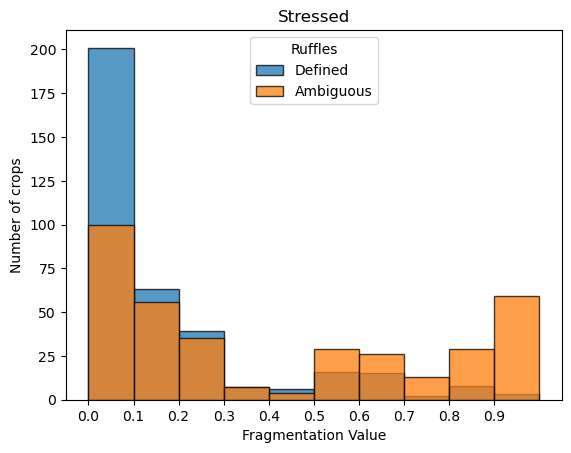

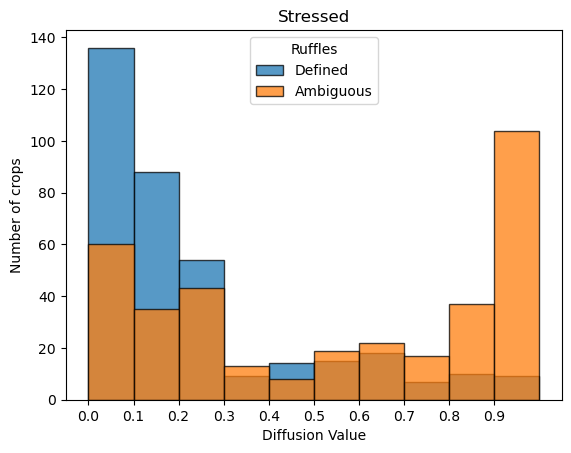

In [21]:
# Same but by condition?
legend_labels = ('Defined', 'Ambiguous')
for cond in np.unique(data['conditions']):
    print(cond)
    conditions = np.array(data['conditions'].values.tolist())
    x = np.array(data['features'].values.tolist())
    x = x[conditions == cond]
    for f, title in zip((2,3), ('Fragmentation', 'Diffusion')):
        x_f = x[:,f]
        for c in np.unique(classes):
            x_class = x_f[classes[conditions == cond] == c]
            hist = plt.hist(x_class, bins=np.arange(0,1.1,0.1), alpha=0.75, edgecolor='black', rwidth=1, label=legend_labels[c*1], density=False)
        plt.title(cond)
        plt.ylabel('Number of crops')
        plt.xlabel(f'{title} Value')
        plt.xticks(np.arange(0,1.0,0.1), np.arange(0.0,1.0,0.1).astype('float32'))
        plt.legend(title='Ruffles', loc='upper center')
        plt.show()
        plt.close()

In [ ]:
for img_name in np.unique(data['images']):
    img_df = data.loc[data['images'] == img_name]
    im_y = y[data['images'] == img_name]
    im_coords = img_df['coords'].values.tolist()

    #im_y = y[images == img_name]
    #im_coords = coords[images == img_name]

    image = load_image(img_name)
    localize_clusters(image, im_coords, im_y, n_examples=5, n_clusters=n_clusters, im_name=img_name)
    plt.title('Clustering Classes')
    plt.savefig(f'clustering_{img_name[:-4]}.pdf', bbox_inches='tight', dpi=450)
    plt.show()
    plt.close()

### MIP vs slice

F2180j_cldn3-green_factin-red_40X_pic3_MIP
images/MIP_vs_slice/F2180j_cldn3-green_factin-red_40X_pic3_MIP\output\patchlist.txt


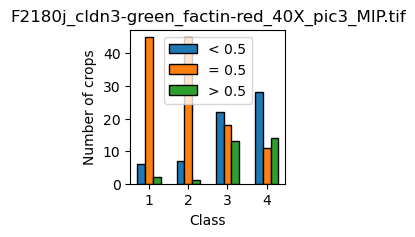

F2180j_cldn3-green_factin-red_40X_pic3_z5
images/MIP_vs_slice/F2180j_cldn3-green_factin-red_40X_pic3_z5\output\patchlist.txt


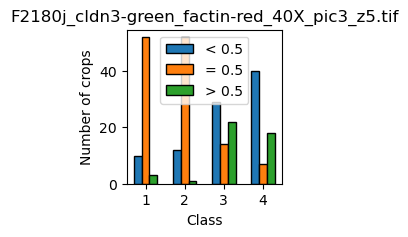

Fstr2192j_cldn3-green_factin-red_40X_pic4_MIP
images/MIP_vs_slice/Fstr2192j_cldn3-green_factin-red_40X_pic4_MIP\output\patchlist.txt


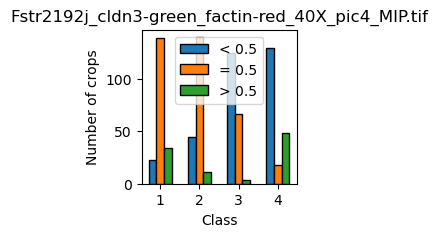

Fstr2192j_cldn3-green_factin-red_40X_pic4_z10
images/MIP_vs_slice/Fstr2192j_cldn3-green_factin-red_40X_pic4_z10\output\patchlist.txt


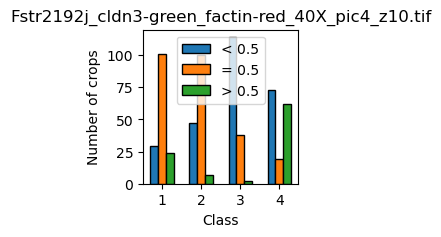

In [24]:
#paths = ('patchlist1_32.txt', 'patchlist2.txt', 'patchlist3_ancienLog_32_nouveauLog.txt', 'patchlist4.txt', 'patchlist5.txt')
condition_paths = {'Control'  : ['F2180j_cldn3-green_factin-red_40X_pic3_MIP', 'F2180j_cldn3-green_factin-red_40X_pic3_z5'],
                   'Stressed' : ['Fstr2192j_cldn3-green_factin-red_40X_pic4_MIP', 'Fstr2192j_cldn3-green_factin-red_40X_pic4_z10']}

feature_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

features_list, coords_list, images_list, structures_list, conditions_list, ambiguous_list = [], [], [], [], [], []

for cond in condition_paths.keys():
    for i, p in enumerate(condition_paths[cond]):
        print(p)
        data_path = glob.glob(f'images/MIP_vs_slice/{p}/*/patchlist*')[0]
        print(data_path)
        
        features, coords, images, structures, ambiguous = patch_list_to_points(data_path, filter=False, structures=(1,2))

        class_counts = count_classes(classify_by_values(np.array(features)[np.array(structures) == 1]))
        plot_bars(class_counts, images[0])

        features_list.append(features)
        coords_list.append(coords)
        images_list.append(images)
        structures_list.append(structures)
        conditions_list.append([cond for _ in range(len(images))])
        ambiguous_list.append(ambiguous)

# TODO: A nice pandas dataframe instead of this stupid thing
features, coords, images, structures, conditions, ambiguous = combine_labels(features_list, coords_list, images_list, structures_list, conditions_list, ambiguous_list)

# Impute missing/unclear labels
#features = np.array(features)
#print(features)
#print(np.array(ambiguous))
#features[ambiguous] = np.nan
#features = impute_missing_labels(features, n_neighbors=5)
#features = features.tolist()

df_dict = {'features': features,
           'coords': coords,
           'images': images,
           'structures': structures,
           'conditions': conditions,
           'ambiguous': ambiguous}

data = pd.DataFrame(df_dict)
